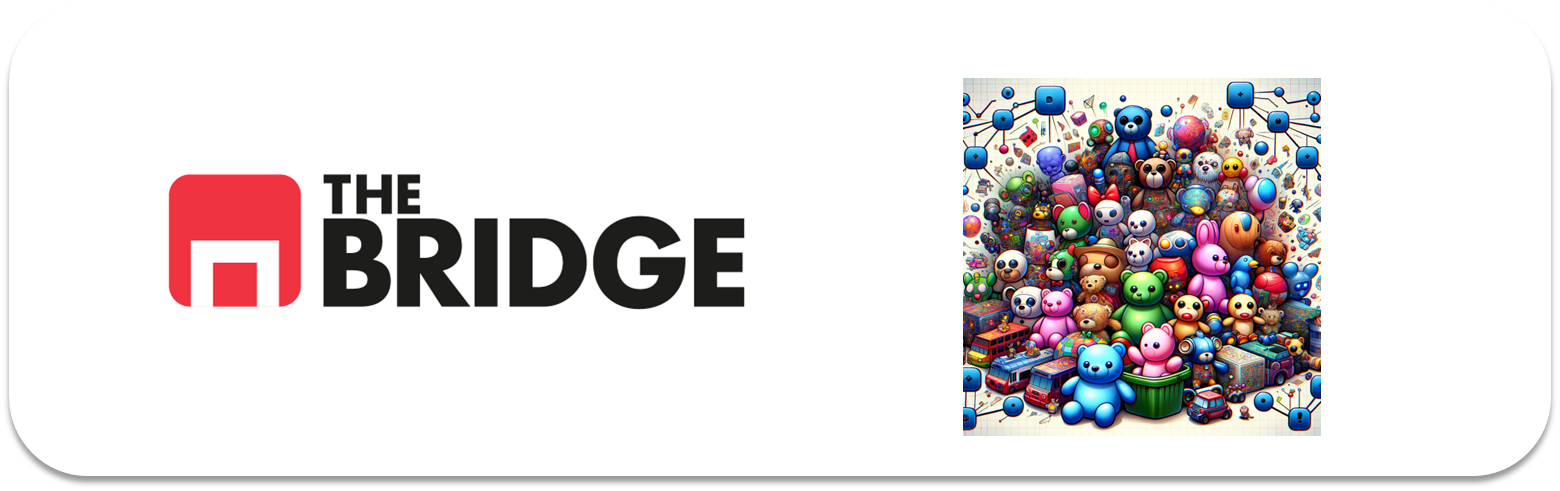

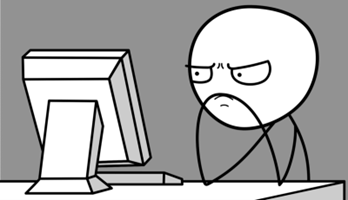

## PRACTICA OBLIGATORIA: K-MEANS

* La práctica obligatoria de esta unidad consiste en un ejercicio de modelado no supervisado sobre imágenes para practicar con el algoritmo k-means. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [1]:
# Importación de librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler


## **#1**

Vamos a trabajar con un dataset también entre los "clásicos" (aunque a veces menos conocido) que es el de rostros Olivetti. Este dataset contiene 400 imágenes en escala de grises de 64 × 64 píxeles de rostros.   


Como en otros datasets de imágenes, estás están "aplanadas" de forma que cada pixel es una feature y por cada imagen hay $64\times 64 = 4096$ features.  

Se fotografiaron 40 personas diferentes (10 veces cada una) y esas fotografías se recogen en el dataset.  

La tarea habitual es entrenar un modelo que pueda predecir qué persona está representada en cada imagen, pero nosotros lo vamos a hacer de forma no supervisada. 



### #1.1


Carga el conjunto de datos usando la función `sklearn.datasets.fetch_olivetti_faces()`. Recuerda que se carga un "diccionario". Muestra su descripción acudiendo a la clave "DESCR".

In [2]:
# Importar la función correctamente
from sklearn.datasets import fetch_olivetti_faces

# Cargar el dataset de rostros Olivetti
faces = fetch_olivetti_faces(shuffle=True, random_state=42)

# Mostrar descripción del dataset
print(faces.DESCR)


.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position
    (with tolerance for some side movement).

**Data Set Characteristics:**

=================   =====================
Classes              

### #1.2 

Aunque no lo vas a usar hasta el final de la práctica, muestra el target. Luego cargalo todo en un mismo dataframe (tendrás que añadir el target) y obtén otro dataset con todas las imagenes reordenadas aleatoriamente (emplea por ejemplo el método `sample` del dataframe o el método que tú quieras)

In [3]:
import pandas as pd

# Extraer las imágenes y etiquetas
X = faces.data  # Cada fila es una imagen aplanada (64x64 = 4096 features)
y = faces.target  # Etiqueta de cada imagen (identidad de la persona)

# Crear un DataFrame con las imágenes y el target
df_faces = pd.DataFrame(X)
df_faces["target"] = y

# Mostrar las primeras filas
df_faces.head()


,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,target
0,0.198347,0.235537,0.351240,0.409091,0.421488,0.429752,0.500000,0.528926,0.524793,0.553719,...,0.508264,0.524793,0.504132,0.483471,0.471074,0.285124,0.061983,0.128099,0.090909,20
1,0.185950,0.128099,0.115702,0.132231,0.185950,0.268595,0.433884,0.541322,0.570248,0.586777,...,0.396694,0.409091,0.301653,0.421488,0.462810,0.247934,0.190083,0.210744,0.210744,28
2,0.508264,0.603306,0.619835,0.628099,0.657025,0.665289,0.690083,0.727273,0.743802,0.768595,...,0.301653,0.305785,0.314050,0.326446,0.338843,0.330579,0.334711,0.342975,0.342975,3
3,0.136364,0.140496,0.185950,0.280992,0.318182,0.363636,0.409091,0.417355,0.438017,0.454545,...,0.169421,0.206612,0.276859,0.355372,0.685950,0.661157,0.280992,0.371901,0.276859,21
4,0.652893,0.644628,0.652893,0.706612,0.714876,0.719008,0.743802,0.747934,0.747934,0.756198,...,0.074380,0.074380,0.082645,0.082645,0.111570,0.070248,0.086777,0.185950,0.231405,9


### #1.3

Vamos a dividir en train y test, pero OJO RECUERDA QUE EN LOS PROBLEMAS NO SUPERVISADOS NO HAY SPLIT (porque no hay target), aquí lo hacemos para poder comparar posteriormente el clustering con la clasificación (ya que es uan práctica formativa).

Por tanto, divídelo en un conjunto de entrenamiento, un conjunto de validación y un conjunto de pruebas (80-10-10). Dado que el conjunto de datos es bastante pequeño, emplea un muestreo estratificado para asegurarse de que haya el mismo número de imágenes por persona en cada conjunto (estratificando por la columna que contenga el target)

NOTA: No hemos hecho hasta ahora la separación en tres sets, investiga por tu cuenta o bien haz primero un split 90-10 y luego otro split 89-11 sobre el de 80 (para que de los números aproximados), por ejemplo.

In [4]:
from sklearn.model_selection import train_test_split

# División en 80% entrenamiento, 20% temporal (que luego dividiremos en validación y test)
X_train, X_temp, y_train, y_temp = train_test_split(df_faces.drop(columns=['target']), df_faces['target'], 
                                                    test_size=0.2, stratify=df_faces['target'], random_state=42)

# División de X_temp en 50% validación y 50% test (equivalente a 10% cada uno del total)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, 
                                                    test_size=0.5, stratify=y_temp, random_state=42)

# Mostrar los tamaños de los conjuntos
print(f"Tamaño Train: {X_train.shape}, Validación: {X_valid.shape}, Test: {X_test.shape}")


Tamaño Train: (320, 4096), Validación: (40, 4096), Test: (40, 4096)


### #1.4

Crea los pares X,y para train, validation y test.

In [5]:
# Convertir los conjuntos de datos en pares (X, y)
X_train = X_train.to_numpy()
X_valid = X_valid.to_numpy()
X_test = X_test.to_numpy()

y_train = y_train.to_numpy()
y_valid = y_valid.to_numpy()
y_test = y_test.to_numpy()

# Verificar dimensiones después de la conversión
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_valid: {X_valid.shape}, y_valid: {y_valid.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


X_train: (320, 4096), y_train: (320,)
X_valid: (40, 4096), y_valid: (40,)
X_test: (40, 4096), y_test: (40,)


Utiliza la siguiente función para visualizar alguna de las caras (observa que tienes que dar la X y la y, usa iloc en ambos datasets)

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Función para visualizar un conjunto de imágenes
def plot_faces(faces, labels, n_cols=5):
    faces = faces.to_numpy().reshape(-1, 64, 64)  # Reconvertir a imágenes 64x64
    n_rows = len(faces) // n_cols + 1  # Calcular filas necesarias
    plt.figure(figsize=(n_cols * 2, n_rows * 2))  # Ajustar el tamaño de la figura
    
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(f"ID: {label}")
    
    plt.show()

# Mostrar algunas caras del conjunto de entrenamiento
plot_faces(X_train, y_train, n_cols=5)


AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

### #1.5

Para acelerar las cosas, reduciremos la dimensionalidad de los datos utilizando PCA (técnica que veremos en el siguiente sprint). Modifica la siguiente celda de forma que las X se correspondan con las que has utilizado en el ejercicio anterior.

In [7]:
from sklearn.decomposition import PCA

pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

pca.n_components_

221

### 1.6

Aquí viene la parte del león. A continuación, agrupa las imágenes utilizando K-Means sobre el dataset de train reducido en el ejercicio anterior. Emplea el método del máximo de score de silueta para obtener el mejor k, probando con K de 5 en 5 hasta 150. ¿Cuál es el k que proporciona el mejor score de silueta? NOTA: Emplea todas las features (no hace falta seleccionar, y ya están escaladas entre 0 y 1)

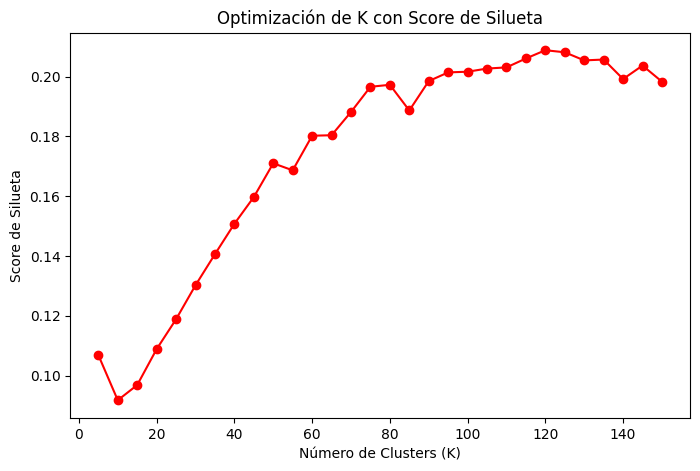

Mejor número de clusters según Score de Silueta: 120


In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

silhouette_scores = []
K_range = range(5, 151, 5)  # Probamos K desde 5 hasta 150 en incrementos de 5

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_train_pca)
    score = silhouette_score(X_train_pca, labels)
    silhouette_scores.append(score)

# Graficar la evolución del Score de Silueta
plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker="o", color="red")
plt.xlabel("Número de Clusters (K)")
plt.ylabel("Score de Silueta")
plt.title("Optimización de K con Score de Silueta")
plt.show()

# Seleccionar el mejor K basado en el máximo Score de Silueta
best_k = K_range[np.argmax(silhouette_scores)]
print(f"Mejor número de clusters según Score de Silueta: {best_k}")



### #1.7

Repite el ejercio anterior empleando ahora el método del codo de Inercia. ¿Sale algo más concluyente o que refuerce el anterior resultado?

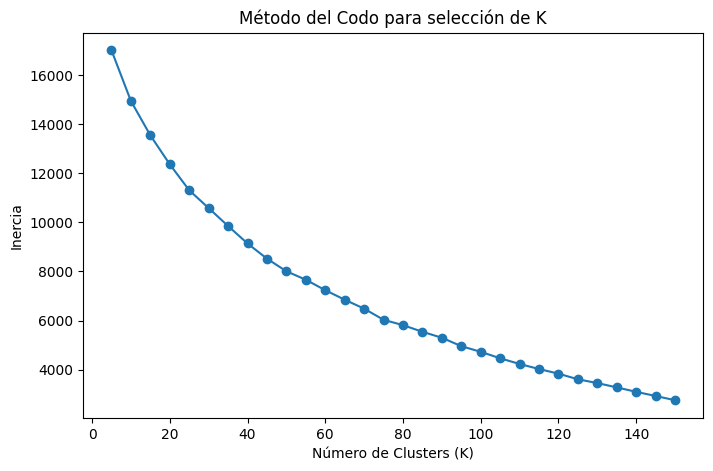

In [ ]:
# Calcular la inercia para diferentes valores de K
inertia = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train_pca)
    inertia.append(kmeans.inertia_)

# Graficar el Método del Codo
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker="o")
plt.xlabel("Número de Clusters (K)")
plt.ylabel("Inercia")
plt.title("Método del Codo para selección de K")
plt.show()


### #1.8

Quédate con el k obtenido con el método del score de silueta y asigna el modelo con ese k a una variable `best_model`

In [ ]:
# Definir el mejor número de clusters basado en los análisis previos
final_k = best_k  # Puedes ajustarlo manualmente si el método del codo sugiere otro valor

# Entrenar el modelo final de K-Means
best_model = KMeans(n_clusters=final_k, random_state=42, n_init=10)
best_model.fit(X_train_pca)

# Asignar las etiquetas de cluster a los datos de entrenamiento
train_labels = best_model.labels_

# Mostrar la cantidad de elementos en cada cluster
unique, counts = np.unique(train_labels, return_counts=True)
cluster_distribution = dict(zip(unique, counts))
print("Distribución de imágenes por cluster:", cluster_distribution)


Distribución de imágenes por cluster: {0: 3, 1: 4, 2: 6, 3: 5, 4: 2, 5: 3, 6: 4, 7: 7, 8: 4, 9: 4, 10: 3, 11: 4, 12: 1, 13: 5, 14: 3, 15: 4, 16: 2, 17: 7, 18: 3, 19: 7, 20: 3, 21: 4, 22: 2, 23: 5, 24: 2, 25: 2, 26: 2, 27: 4, 28: 4, 29: 3, 30: 2, 31: 1, 32: 3, 33: 4, 34: 4, 35: 2, 36: 2, 37: 6, 38: 2, 39: 2, 40: 4, 41: 2, 42: 3, 43: 5, 44: 3, 45: 1, 46: 3, 47: 3, 48: 3, 49: 1, 50: 2, 51: 3, 52: 3, 53: 2, 54: 2, 55: 3, 56: 3, 57: 2, 58: 1, 59: 2, 60: 4, 61: 5, 62: 2, 63: 1, 64: 3, 65: 1, 66: 5, 67: 5, 68: 6, 69: 1, 70: 2, 71: 4, 72: 1, 73: 2, 74: 2, 75: 2, 76: 3, 77: 1, 78: 3, 79: 3, 80: 2, 81: 2, 82: 1, 83: 3, 84: 2, 85: 2, 86: 2, 87: 4, 88: 2, 89: 3, 90: 2, 91: 1, 92: 3, 93: 1, 94: 2, 95: 1, 96: 1, 97: 1, 98: 1, 99: 3, 100: 1, 101: 3, 102: 4, 103: 1, 104: 2, 105: 1, 106: 1, 107: 1, 108: 2, 109: 2, 110: 2, 111: 2, 112: 2, 113: 1, 114: 1, 115: 4, 116: 1, 117: 1, 118: 1, 119: 1}


### #1.9

Haz una valoración del método de clustering para el K elegido. Para ello crea un programa que recorra la lista de etiquetas dadas por "best_model" y que, haciendo uso de la función que ya te hemos proporcionado, pinte las caras asignadas a los 10 primeros clústeres. Ojo tendrás que hacer una pequeña adaptación porque las features de entrenamiento no son las features reales (son una "transformación" de estas) y si pasas el X de entrenamiento no verás nada. ¿Ves caras similares?

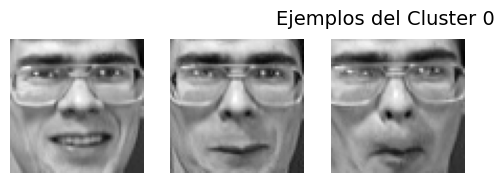

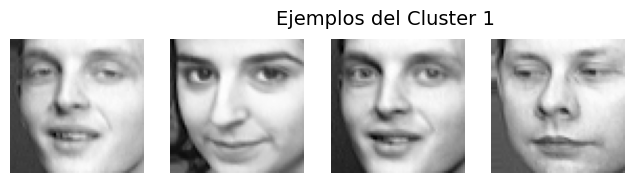

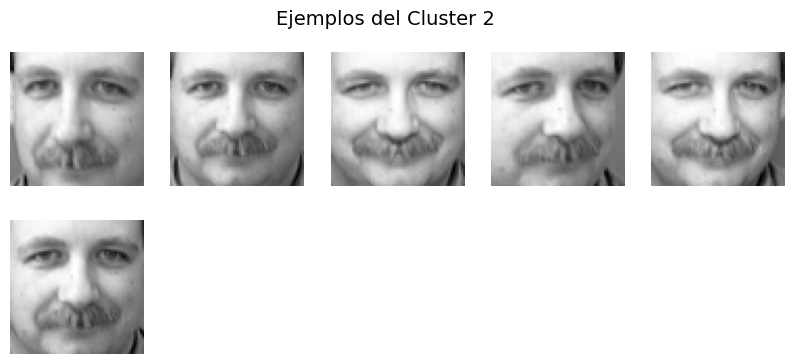

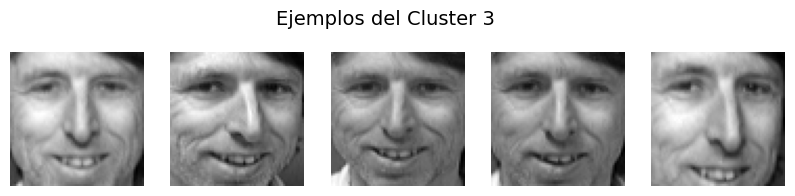

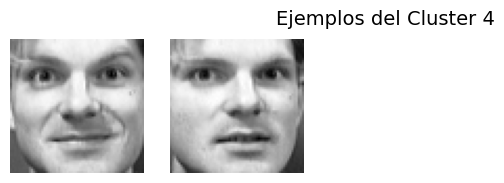

In [ ]:
# Función para visualizar imágenes de un cluster específico
def plot_cluster_faces(X_data, cluster_labels, cluster_number, n_cols=5):
    """
    Muestra imágenes de un cluster específico.
    X_data: imágenes a visualizar.
    cluster_labels: etiquetas asignadas por K-Means.
    cluster_number: número del cluster que queremos ver.
    n_cols: número de imágenes por fila.
    """
    faces_cluster = X_data[cluster_labels == cluster_number]  # Filtrar imágenes del cluster
    faces_cluster = faces_cluster.reshape(-1, 64, 64)  # Volver a dar forma 64x64
    
    n_rows = len(faces_cluster) // n_cols + 1  # Calcular filas necesarias
    plt.figure(figsize=(n_cols * 2, n_rows * 2))
    
    for index, face in enumerate(faces_cluster[:n_cols * n_rows]):  # Mostrar hasta completar la cuadrícula
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
    
    plt.suptitle(f"Ejemplos del Cluster {cluster_number}", fontsize=14)
    plt.show()

# Visualizar ejemplos de los primeros 5 clusters
for cluster in range(min(5, final_k)):  # Máximo 5 clusters a visualizar
    plot_cluster_faces(X_train, best_model.labels_, cluster, n_cols=5)


## **#2**


### #2.1


Continuando con el conjunto de datos de caras Olivetti, entrena un clasificador para predecir qué persona está representada en cada imagen, y evalúalo en el conjunto de validación. Utiliza un RandomForest con 150 submodelos o estimadores (y el resto de hiperparámetros déjalos a su valor por defecto)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Definir y entrenar el modelo Random Forest
clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_pca, y_train)

# Evaluación en el conjunto de validación
y_valid_pred = clf.predict(X_valid_pca)
accuracy_valid = accuracy_score(y_valid, y_valid_pred)

# Mostrar la precisión del modelo en validación
print(f"Accuracy en Validación: {accuracy_valid:.4f}")


Accuracy en Validación: 0.9250


### #2.2

Utiliza K-Means como una herramienta de reducción de dimensionalidad y entrena un clasificador en el conjunto reducido. Para ello emplea el método transform de manera que ahora las features de entrada sean las distancias de cada punto a los centroides del modelo "best_model" de la parte anterior. Por ejemplo:
```python
X_train_reduced = best_model.transform(X_train_pca) 
```


Ojo lo tienes que aplicar a todos los datasets. Luego vuelve a entrenar un RandomForest sobre este dataset y evalualo contra el dataset de validacion.

In [ ]:
# Transformar los datos usando los centroides de K-Means
X_train_reduced = best_model.transform(X_train_pca)
X_valid_reduced = best_model.transform(X_valid_pca)
X_test_reduced = best_model.transform(X_test_pca)

# Entrenar Random Forest con la nueva representación
clf_reduced = RandomForestClassifier(n_estimators=150, random_state=42)
clf_reduced.fit(X_train_reduced, y_train)

# Evaluación en validación
y_valid_pred_reduced = clf_reduced.predict(X_valid_reduced)
accuracy_valid_reduced = accuracy_score(y_valid, y_valid_pred_reduced)

# Mostrar la precisión del modelo con reducción K-Means
print(f"Accuracy en Validación con Reducción de K-Means: {accuracy_valid_reduced:.4f}")


Accuracy en Validación con Reducción de K-Means: 0.8000


### #2.3 EXTRA VOLUNTARIO

Busca el número de clusters k que generen un algoritmo kmeans que a su vez sus distancias a los centroides sean las features de un clasificador RandomForest y que permita al clasificador obtener el mejor rendimiento: ¿Qué rendimiento puedes alcanzar? (en terminos de Accuracy)

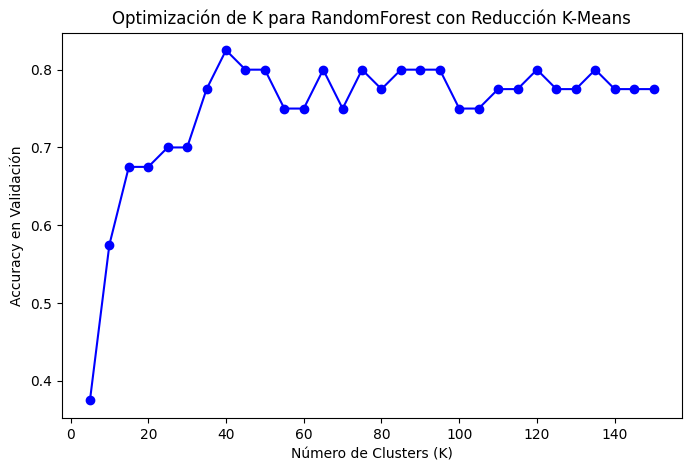

Mejor K para RandomForest con Reducción K-Means: 40 con Accuracy: 0.8250


In [ ]:
best_accuracy = 0
best_k_rf = None
accuracy_scores = []

# Probar diferentes valores de K (5 a 150 en pasos de 5)
for k in K_range:
    # Entrenar K-Means con K clusters
    kmeans_rf = KMeans(n_clusters=k, random_state=42, n_init=10)
    X_train_rf = kmeans_rf.fit_transform(X_train_pca)  # Transformar datos de entrenamiento
    X_valid_rf = kmeans_rf.transform(X_valid_pca)  # Transformar datos de validación

    # Entrenar Random Forest con la nueva representación
    clf_rf = RandomForestClassifier(n_estimators=150, random_state=42)
    clf_rf.fit(X_train_rf, y_train)
    
    # Evaluación en validación
    y_valid_pred_rf = clf_rf.predict(X_valid_rf)
    acc = accuracy_score(y_valid, y_valid_pred_rf)
    accuracy_scores.append(acc)

    # Guardar el mejor K basado en la accuracy
    if acc > best_accuracy:
        best_accuracy = acc
        best_k_rf = k

# Graficar la evolución de la precisión en validación
plt.figure(figsize=(8, 5))
plt.plot(K_range, accuracy_scores, marker="o", color="blue")
plt.xlabel("Número de Clusters (K)")
plt.ylabel("Accuracy en Validación")
plt.title("Optimización de K para RandomForest con Reducción K-Means")
plt.show()

# Mostrar el mejor K encontrado
print(f"Mejor K para RandomForest con Reducción K-Means: {best_k_rf} con Accuracy: {best_accuracy:.4f}")
